# Assembling the Analysis

This notebook accounts for periodic boundaries by shifting the whole grid & reclustering. Opposed to the first version, which just reclustered the boundaries.

The goal is to assemble routines for all parts of the analysis. These can than be combined into a script, which loops over a full data folder.

Development steps:
1. set up the periodic clustering
2. verify it works as intended (using pythyon testing functionalities?)
3. set up the analysis
4. define relevant I/O (one file per data set & one combination file)
5. set up the script

Content required for the analysis:
* mass distribution function for different theresholds
* bin mass as a function of radius -> desity profile
  (for every point compute distance to com & desnity)
* sphereicity study from fluctuations of density profile (bin by bin)
* mass versus radius

Possible radius definitions:
* 90% mass from the density profile
* $r = \sqrt{\sum_i m_i r_i^2 / \sum_i m_i}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function

from sklearn.cluster import DBSCAN
from sklearn import metrics

from random import randint
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist

import time
import sys
import h5py

from math import pow
from math import ceil

from numba import jit

from numpy import linalg as LA

## 1. Routines for periodic clustering

### Parameter definition
these schould later be part of the class

In [2]:
# DBSCAN parameters -> same for all executions
eps=2
min_samples=20
algorithm='kd_tree'
n_jobs=-1

# problem specific parameters
dens_th = 5
data_file = '../data/l1024/axion.r.10901'

### a quick investiagtion of javiers data files

this doesn't need to go in the code but is for my reference

In [58]:
def check_hdf5_content(filename):
    
    file = h5py.File(filename, 'r')

    for item in file.attrs.keys():
        print(item + ":", file.attrs[item])
    print(' ')
    
    for item in file.keys():
        print(item + ":", file[item].keys())
        
    file.close()

In [61]:
check_hdf5_content('../data/l1024/axion.m.10901')

Field type: Axion
Precision: Single
Size: 1024
Depth: 1024
Lambda: 13.1072
nQcd: 7.0
Physical size: 3.0
z: 5.00041864342
zInitial: 0.5
zFinal: 1.0
nSteps: 500
Current step: 1090100
 
energy: [u'density']


In [62]:
check_hdf5_content('../data/l1024/axion.r.10901')

Field type: Axion
Precision: Single
Size: 128
Depth: 128
Lambda: 13.1072
nQcd: 7.0
Physical size: 3.0
z: 5.00041864342
zInitial: 0.5
zFinal: 1.0
nSteps: 500
Current step: 1090100
 
energy: [u'density']


In [66]:
check_hdf5_content('../data/l2048/axion.m.00001')

Field type: Saxion
Precision: Single
Size: 2048
Depth: 2048
Lambda: 101250.0
nQcd: 0
Physical size: 5.2
z: 0.104166666667
zInitial: 0.05
zFinal: 2.65
nSteps: 6144
Current step: 128
 
energy: []
map: [u'm', u'v']
point: [u'value']
string: [u'data']


### read in the data file
this should become part of the constructor

ToDo:
* is the reshape command I found in Javiers code necessary
* n, n2, n3, sizeL should become class members

In [59]:
# new style data -> taken from javiers code
file = h5py.File(data_file, 'r')

n = file.attrs[u'Size']
sizeL = file.attrs[u'Physical size']

n2 = n*n
n3 = n2*n

print('# of grid points per direction: %d' %(n))
print('physical size of the grid: %d' %(sizeL))

# is the reshape necessary?
#print (data.shape)
data = file['energy/density'].value.reshape(n3)
#print (data.shape)
file.close()

# of grid points per direction: 128
physical size of the grid: 3


### extract relevant information
this should become a method for the class (requiring only the density thereshold as input parameter)
it could write the results to a sub-class, i.e. you create one class which holds general information & several sub-classes for every density thereshold

return values:
* \# of points above thereshold
* positin array of
* array of densities
* massfraction above thereshold

possible tests:
* array of densities can't contain points below thereshold
* test with created data that the locations are correct & the mass fraction

In [11]:
def basicstuff(data, dens_th) : 
    
    # mask all points below the density thereshold
    mask = ( data > dens_th)
    
    # create three arrays containing the x, y, and z position of every point on the full grid
    bas = np.zeros((n,n,n),dtype=float)
    linap = np.arange(0,n,dtype=float).reshape((n,1,1))
    x_pos = bas + linap
    y_pos = bas + linap.reshape((1,n,1))
    z_pos = bas + linap.reshape((1,1,n))
    del bas, linap
    x_pos = np.reshape(x_pos,(n3,))
    y_pos = np.reshape(y_pos,(n3,))
    z_pos = np.reshape(z_pos,(n3,))

    # create an empty array to hold the positions
    npo = len(x_pos[mask])
    pos = np.empty((npo,3))
    
    # apply mask to only get the positions above thereshold
    # write to position array
    pos[:,0] = x_pos[mask]
    pos[:,1] = y_pos[mask]
    pos[:,2] = z_pos[mask]
    
    #apply mask to get the density array
    den = data[mask]
    
    fractionofmass = np.add.reduce(den)/n3
    print('for thereshold %d: returned %d points containing %.1f/100 of the mass'%(dens_th, npo,100*fractionofmass))
    return npo, pos, den, fractionofmass

In [60]:
npo, pos, den, massfraction = basicstuff(data, dens_th)

for thereshold 5: returned 77689 points containing 68.1/100 of the mass


### plot the data above thereshold

this is just a crosscheck
-> decide if it should be part of the final code

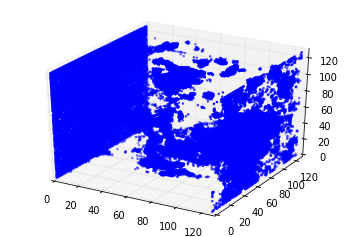

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0, n)
ax.set_ylim3d(0, n)
ax.set_zlim3d(0, n)
ax.scatter(pos[:,0], pos[:,1], pos[:,2], s=6, lw=0)

plt.show()

### obtain the labels

In [32]:
# 1. cluster the original data set
start = time.time()
db = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm, n_jobs=n_jobs).fit(pos)
labels = np.array(db.labels_)
end = time.time()
nmc1 = len(set(labels))
print('clustering original data setreturned %d clusters and took %1.3f s' %(nmc1,end-start))

nh = n//2

# 2. shift the data by n/2 and take mod(n)
pos2 = (pos + [nh,nh,nh])%n

# 3. cluster the shifted data set
start = time.time()
db2 = DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm, n_jobs=n_jobs).fit(pos2)
labels2 = np.array(db2.labels_)
nmc2 = len(set(labels2))
end = time.time()
print('clustering shifted data set returned %d clusters and took %1.3f s' %(nmc2,end-start))

clustering original data setreturned 66 clusters and took 1.840 s
clustering shifted data set returned 129 clusters and took 1.930 s


### Plot the clustered data

In [33]:
def plot_clusters_3D (pos, labels):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim3d(0, n)
    ax.set_ylim3d(0, n)
    ax.set_zlim3d(0, n)

    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    for k, col in zip(unique_labels, colors):
        if (k>-1):

            class_member_mask = (labels == k)
            xyz = pos[class_member_mask] #list of coordinates of all points in one cluster

            ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=col, s=6, lw=0)

    plt.show()

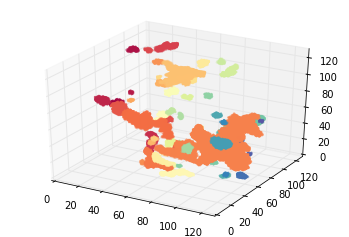

In [35]:
plot_clusters_3D(pos,labels)

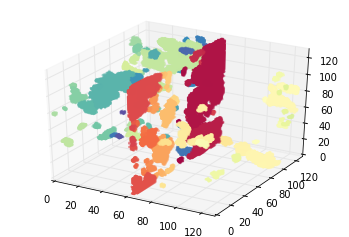

In [36]:
plot_clusters_3D(pos2,labels2)

### account for periodic boundaries

needed tests:
* try with mock data: is the number of clusters etc found correctly
* try with random data sets: after the relabeling process a second shift should not have any effect
* test with mock data if clusters in set 2 but noise in set1 are accounted for correctly

we can think of implementing the second test as part of the code for every data set depending on how much time it takes

To Do:
* rename the sex-function

In [21]:
def sex (labels,labels2):
    
    npo = len(labels)
        
    # auxillary label matrices    
    newlabels = np.zeros(npo,dtype=int) -2
    labels11 = np.zeros(npo,dtype=int)
    labels22 = np.zeros(npo,dtype=int)
    
    labels11[:] = labels
    labels22[:] = labels2
    

    # create list with first index at which a label in labels appears (po1)
    m1 = max(labels)
    jta = np.arange(0,npo,dtype=int)

    po1 = []
    # for i in xrange(1,m1+1)
    for j in set(labels):
        if j > -1:
            parla1 = (labels  == j)
            po1.append(jta[parla1][0])
    po1 = np.array(po1)
      
    # account for all points which are marked as noise in both datasets
    parla1 = (labels  == -1)
    parla2 = (labels2 == -1)

    newlabels[parla1*parla2]   = -1
    labels11[parla1*parla2] = -2
    labels22[parla1*parla2] = -2

    dicta = []    
    # clusters UNION
    for i in set(labels): 
        if i > -1:
            # reference point
            posi = po1[i]
            ll = labels[posi]
            
            # get the cluster of this point in both labeling systems
            parla1 = (labels  == ll)
            parla2 = (labels2 == labels2[posi])
               
            # if the point labels two clusters, group them
            if labels2[posi] > -1 :
                # all points which belon to at leas one of the labels
                mask = np.logical_or(parla1,parla2)
                # set of newlabels in mask
                seta = np.array(list(set(newlabels[mask])))
                # remove noise and yet unlabeled points
                seta = seta[seta > -1]
                
                # actually some of the points found may already be part of a cluster
                # account for all points in that cluster
                if len(seta) > 1:
                    for lset in seta:
                        minimask = (newlabels == lset)
                        mask = np.logical_or(mask,minimask)
                    ll = min(seta)
                    
                newlabels[mask] = ll
                labels11[mask] = -2
                labels22[mask] = -2
                
            # if the point belongs to a mc in case 1 but not in case 2:
            # only take the points from case 1 & edit in newlabels
            # the opposite case is accounted for below
            elif labels2[posi] == -1 :
                mask = parla1 
                newlabels[mask] = ll
                labels11[mask] = -2
            
            # store information about which labels have been grouped together
            # TODO: why not also store the new label
            dicta.append([labels[posi],labels2[posi]])
        
            
    maxrelab = max(newlabels)

    # account for MCs which are completely made up of noise in set 1 but combine to a cluster in set 2
    rela2 = np.array(list(set(labels22)))

    counter = 0
    
    for j in rela2:
        if j > -1 :        
            parla22 = (labels22  == j)
            # this part was change from Javiers initial code
            # must anypoint of this MC need be asssotiated with a mc already present in newlabels?
            #asolabel = np.array(list(set(labels2[parla22])))
            asolabel = np.array(list(set(newlabels[parla22])))
            print(j, asolabel)
            asolabel = asolabel[asolabel > -1]

            ll2 = j
            
            if asolabel == []:    
                newlabels[parla22] = maxrelab + counter
                counter +=1 
                dicta.append([-1,ll2])
            elif len(asolabel) > 0:
                lala = min(asolabel)

                for l in asolabel:
                    para = (newlabels == l)
                    newlabels[para] = lala
                    dicta.append([lala,j])
                newlabels[parla22] = lala
                
            labels11[parla22] = -2
            labels22[parla22] = -2    
                
    return newlabels, list(dicta)


In [22]:
newlabels, dicta = sex(labels,labels2)

0 [-2]
1 [-2]
2 [-2]
3 [-2]
4 [-2]
5 [-2]
6 [-2]
7 [-2]
8 [-2]
9 [-2]
10 [-2]
11 [-2]
12 [-2]
13 [-2]
14 [-2]
15 [-2]
17 [-2]
18 [-2]
19 [-2]
20 [-2]
21 [-2]
22 [-2]
23 [-2]
24 [-2]
25 [-2]
26 [-2]
27 [-2]
28 [-2]
29 [-2]
30 [-2]
31 [-2]
32 [-2]
33 [-2]
34 [-2]
35 [-2]
36 [-2]
37 [-2]
38 [-2]
39 [-2]
40 [-2]
41 [-2]
42 [-2]
43 [-2]
44 [-2]
45 [-2]
46 [-2]
47 [-2]
48 [-2]
49 [-2]
50 [-2]
83 [-2]
87 [32]
89 [33]


### print the clustered distribution

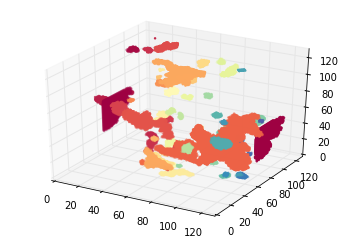

In [25]:
plot_clusters_3D(pos, newlabels)

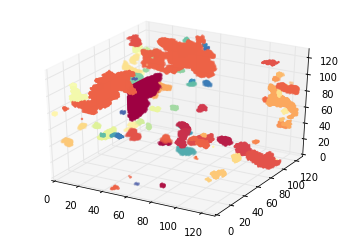

In [26]:
plot_clusters_3D(pos2, newlabels)

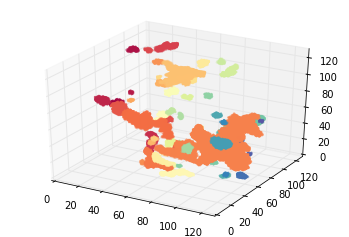

In [27]:
plot_clusters_3D(pos, labels)

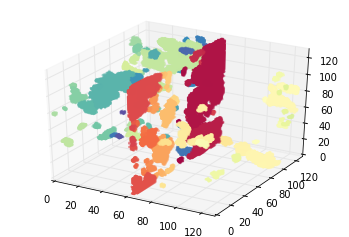

In [30]:
plot_clusters_3D(pos2, labels2)